## imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
train=pd.read_csv("/kaggle/input/the-bards-best-a-character-modeling-dataset/train.csv")

## input Dataset

In [3]:
input=train.iloc[0][0]

/tmp/ipykernel_30/1481203477.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input=train.iloc[0][0]


In [4]:
print(input[0:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [38]:
print("length of dataset",len(input))

length of dataset 1003854


In [7]:
chars=sorted(list(set(input)))
vocab_size=len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Create a mapping from characters to integers

In [8]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
#

## One possible tokeniser

In [9]:
encode= lambda s:[stoi[c] for c in s]
decode = lambda l:"".join([itos[i] for i in l])

print(encode("hi there"))
print(decode(encode("hi there")))

[46, 47, 1, 58, 46, 43, 56, 43]
hi there


## Tiktoken(Byte-Pair encoding tokenizer)

In [27]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:0000:0100:01


In [28]:
import tiktoken

In [30]:
enc=tiktoken.get_encoding("gpt2")
enc.n_vocab

50257

In [33]:
enc.encode("hi there")
enc.decode(enc.encode("hi there"))

'hi there'

## Tokenizing train data

In [36]:
import torch
data=torch.tensor(encode(input))
print(data.shape,data.dtype)
print(data[:1000])

torch.Size([1003854]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [39]:
n=int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

## Training strategy
We train the model in batches.This has two advantages
 1. It is computationally efficient
 2. It makes the transformer network see contexts from 1 to block size.This allows for variable length predictions 

In [41]:
block_size=8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [42]:
x=train_data[:block_size]
y=train_data[1:block_size+1]
for t in range(block_size):
    context=x[:t+1]
    target=y[1]
    print(f"when input is {context} the target:{target}")

when input is tensor([18]) the target:56
when input is tensor([18, 47]) the target:56
when input is tensor([18, 47, 56]) the target:56
when input is tensor([18, 47, 56, 57]) the target:56
when input is tensor([18, 47, 56, 57, 58]) the target:56
when input is tensor([18, 47, 56, 57, 58,  1]) the target:56
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target:56
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target:56


### Data's random sampling

In [43]:
torch.manual_seed(42)
batch_size=4 # this is the no of independant squences the transformer will process at once
block_size=8 # this+1 is the maximum context length for prediction 

def get_batch(split):
    data=train_data if split == "train" else val_data
    ix=torch.randint(len(data)-block_size,(batch_size,))
    x=torch.stack([data[i:i+block_size] for i in ix])
    y= torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y

In [45]:
xb,yb=get_batch("train")
print("inputs")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)

inputs
torch.Size([4, 8])
tensor([[46, 47, 41, 46,  1, 47, 57,  1],
        [ 1, 61, 53, 52, 58, 43, 42,  1],
        [39, 56,  1, 46, 47, 51,  1, 52],
        [ 1, 39, 52, 42,  1, 52, 53, 58]])
targets:
torch.Size([4, 8])
tensor([[47, 41, 46,  1, 47, 57,  1, 52],
        [61, 53, 52, 58, 43, 42,  1, 57],
        [56,  1, 46, 47, 51,  1, 52, 43],
        [39, 52, 42,  1, 52, 53, 58,  1]])


In [48]:
for b in range(batch_size):
    for t in range(block_size):
        context=xb[b:t+1]
        target=yb[b,t]
        print(f"when the input is {context.tolist()} target is {target}")

when the input is [[46, 47, 41, 46, 1, 47, 57, 1]] target is 47
when the input is [[46, 47, 41, 46, 1, 47, 57, 1], [1, 61, 53, 52, 58, 43, 42, 1]] target is 41
when the input is [[46, 47, 41, 46, 1, 47, 57, 1], [1, 61, 53, 52, 58, 43, 42, 1], [39, 56, 1, 46, 47, 51, 1, 52]] target is 46
when the input is [[46, 47, 41, 46, 1, 47, 57, 1], [1, 61, 53, 52, 58, 43, 42, 1], [39, 56, 1, 46, 47, 51, 1, 52], [1, 39, 52, 42, 1, 52, 53, 58]] target is 1
when the input is [[46, 47, 41, 46, 1, 47, 57, 1], [1, 61, 53, 52, 58, 43, 42, 1], [39, 56, 1, 46, 47, 51, 1, 52], [1, 39, 52, 42, 1, 52, 53, 58]] target is 47
when the input is [[46, 47, 41, 46, 1, 47, 57, 1], [1, 61, 53, 52, 58, 43, 42, 1], [39, 56, 1, 46, 47, 51, 1, 52], [1, 39, 52, 42, 1, 52, 53, 58]] target is 57
when the input is [[46, 47, 41, 46, 1, 47, 57, 1], [1, 61, 53, 52, 58, 43, 42, 1], [39, 56, 1, 46, 47, 51, 1, 52], [1, 39, 52, 42, 1, 52, 53, 58]] target is 1
when the input is [[46, 47, 41, 46, 1, 47, 57, 1], [1, 61, 53, 52, 58, 43,

# bigram model

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(42)

## hyperparameters

In [12]:
batch_size=32 # this is the no of independant squences the transformer will process at once
block_size=8 # this is the maximum context length for prediction 
max_iters= 3000
eval_inter=300
learning_rate=1e-2
device="cuda" if torch.cuda.is_available() else "cpu"
eval_iters=200

## Train and test splits

In [13]:
data=torch.tensor(encode(input))
n=int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

## Batching

In [14]:
def get_batch(split):
    data=train_data if split == "train" else val_data
    ix=torch.randint(len(data)-block_size,(batch_size,))
    x=torch.stack([data[i:i+block_size] for i in ix])
    y= torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y=x.to(device),y.to(device)
    return x,y

## Estimating Loss

In [25]:
@torch.no_grad()
def estimate_loss():
    out={}
    model.eval()
    for split in ["train","val"]:
        losses=torch.zeros(eval_iters)
        for k in range(eval_iters):
            X,Y=get_batch(split)
            logits,loss=model(X,Y)
            losses[k]=loss.item()
        out[split]=losses.mean()
    model.train()
    return out

In [16]:
vocab_size

65

In [17]:
class bigramLM(nn.Module):
    
    def __init__(self,vocab_size):
        super().__init__()
        #each token directly reads off the logits for the next in the lookup table
        self.token_embedding_table=nn.Embedding(vocab_size,vocab_size)
    
    def forward(self,idx,targets=None):
        #idx and targets are both(b,t) tensor of integers
        logits=self.token_embedding_table(idx) 
        if (targets==None):
            loss=None
        else:
            #making the data conform to pytorch functional format
            B,T,C=logits.shape
            logits=logits.view(B*T,C)
            targets=targets.view(B*T)
            #a loss function
            loss=F.cross_entropy(logits,targets)
        return logits,loss
    
    def generate(self,idx,max_new_tokens):
        #idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            #get predictions
            logits,loss = self(idx)
            #focus only on the last time step
            logits=logits[:,-1,:]#Become (B,C)
            #apply softmax to get probs
            probs=F.softmax(logits,dim=-1)# (B, C)
            #sample form the distribution
            idx_next=torch.multinomial(probs,num_samples=1)#(B ,1)
            #append sampled index to the running sequence
            idx=torch.cat((idx,idx_next),dim=1)#(B,T+1)
        return idx

In [21]:
model=bigramLM(vocab_size)
m=model.to(device)


## Training the bigram model

In [22]:
optimizer=torch.optim.Adam(m.parameters(),lr=learning_rate)

In [26]:
for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_inter == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    # sample a batch of data
    xb, yb = get_batch('train')
    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.5672, val loss 4.5643
step 300: train loss 2.7831, val loss 2.8044
step 600: train loss 2.5327, val loss 2.5725
step 900: train loss 2.4962, val loss 2.5275
step 1200: train loss 2.4816, val loss 2.5111
step 1500: train loss 2.4653, val loss 2.4998
step 1800: train loss 2.4630, val loss 2.5041
step 2100: train loss 2.4600, val loss 2.5141
step 2400: train loss 2.4529, val loss 2.5019
step 2700: train loss 2.4570, val loss 2.5028


In [27]:
idx=torch.zeros((1,1),dtype=torch.long,device=device)
print(decode(m.generate(idx,max_new_tokens=500)[0].tolist()))


SAnequnt, anca seir he hainndswe cerce;
A yo imathimacaloue he borit tl hey t; I'thest w th GAnt s st oure fatldachtored arthulof nod,


S:
Aneotot?
Ther the, ibey.


OULONI ms arire un's!
Yougeme wivere bl denie hes timithaplmadinooth ar Ifit wheapilthar the

Wind INu g t in, 3 lin st wiceair! gouree asor his pis, y, wses ntheresliot avere hef darthimoknt gh kne danong!
Whu,
Filithetus wnonet ast tyofire ttr thoper:
K:
NOLo aks sts wit hes g l bexcve, y cet ck, inefl ke, t
MINDern helowe asure 


In [82]:
# batch_size=32
# for steps in range(10000):
#     xb,yb=get_batch("train")
#     logits,loss=m(xb,yb)
#     optimizer.zero_grad(set_to_none=True)
#     loss.backward()
#     optimizer.step()
    
# print(loss.item())

2.3654510974884033


In [77]:
idx=torch.zeros((1,1),dtype=torch.long)
print(decode(m.generate(idx,max_new_tokens=100)[0].tolist()))


!M:ENbmV,hbPzOi!ug:BfAGB$OE?mtXxuInvVDKaqHvlt;LAKarmtAkCAaAcMVycdKzX uLlRDGMfruBfsTu;Zb Cwr;!DwQdKzW


In [75]:
print(loss)

tensor(4.4476, grad_fn=<NllLossBackward0>)


# Transfomer

### Mathematical trick in self-attention

In [35]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


Version 1:Taking average of previous context window to get prediction

In [28]:
#example
torch.manual_seed(42)
B,T,C=4,8,2#Batch, time , channels
x=torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [31]:
xbow= torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev=x[b,:t+1] #(t,C)
        xbow[b,t]=torch.mean(xprev,0)

In [33]:
x[0]

tensor([[ 1.9269,  1.4873],
        [ 0.9007, -2.1055],
        [ 0.6784, -1.2345],
        [-0.0431, -1.6047],
        [-0.7521,  1.6487],
        [-0.3925, -1.4036],
        [-0.7279, -0.5594],
        [-0.7688,  0.7624]])

In [34]:
xbow[0]

tensor([[ 1.9269,  1.4873],
        [ 1.4138, -0.3091],
        [ 1.1687, -0.6176],
        [ 0.8657, -0.8644],
        [ 0.5422, -0.3617],
        [ 0.3864, -0.5354],
        [ 0.2272, -0.5388],
        [ 0.1027, -0.3762]])

Version 2 Taking average using matrix multiply(See trick for clarificiation on weighted average)

In [37]:
wei= torch.tril(torch.ones(T, T))
wei= wei/wei.sum(1,keepdim=True)
xbow2= wei @ x #(B,T,T) @ (B,T,C) ---> (B,T,C)
torch.allclose(xbow,xbow2)

True

Version 3: Adding Softmax

masked_fil makes all the elments where wei is 0 to negative infinity

In [42]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))

In [43]:
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [47]:
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

In [48]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

you can do weighted aggregations of your past elements by using matrix multiplication of a lower triangular fashion and the elements of the lower triangular part are telling much of each element fuses into this position

Version 4: Self Attention

In [50]:
torch.manual_seed(42)
B,T,C=4,8,32#Batch, time , channels
x=torch.randn(B,T,C)

Single Attention Head(Self-Attention)

In [59]:
head_size=16 #hyperparam
key=nn.Linear(C,head_size,bias=False)
query= nn.Linear(C,head_size, bias=False)
value= nn.Linear(C,head_size, bias=False)
k=key(x) #(B, T, 16)
q=query(x) #(B, T, 16)

In [60]:
#Calculating affinities in queries and keys
wei=q@k.transpose(-2,-1) #(B, T, 16) @ (B,16,T) --> (B, T, T)


we will scale wei to ensure it has more difused values so that the softmax does not become too peaky and converge to one hot values

In [ ]:
wei=q@k.transpose(-2,-1)*head_size**-0.5

In [61]:
tril=torch.tril(torch.ones(T,T))
#wei = torch.zeros((T,T))
# we use mask to ensure past is not influenced by future this is the decoding block, in encoder blocks this line would be excluded
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)


In [62]:
v= value(x)
out = wei @ v

In [63]:
out.shape

torch.Size([4, 8, 16])

In [58]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1905, 0.8095, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3742, 0.0568, 0.5690, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1288, 0.3380, 0.1376, 0.3956, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4311, 0.0841, 0.0582, 0.3049, 0.1217, 0.0000, 0.0000, 0.0000],
        [0.0537, 0.3205, 0.0694, 0.2404, 0.2568, 0.0592, 0.0000, 0.0000],
        [0.3396, 0.0149, 0.5165, 0.0180, 0.0658, 0.0080, 0.0373, 0.0000],
        [0.0165, 0.0375, 0.0144, 0.1120, 0.0332, 0.4069, 0.3136, 0.0660]],
       grad_fn=<SelectBackward0>)

### V2

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F

#### Hyperparams

In [7]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

In [8]:
torch.manual_seed(42)

#### Encoding

In [9]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(input)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

#### Train and val splits

In [10]:
data = torch.tensor(encode(input), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

#### Batching

In [11]:
def get_batch(split):
    data=train_data if split == "train" else val_data
    ix=torch.randint(len(data)-block_size,(batch_size,))
    x=torch.stack([data[i:i+block_size] for i in ix])
    y= torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y=x.to(device),y.to(device)
    return x,y

#### Estimating Loss

In [12]:
@torch.no_grad()
def estimate_loss():
    out={}
    model.eval()
    for split in ["train","val"]:
        losses=torch.zeros(eval_iters)
        for k in range(eval_iters):
            X,Y=get_batch(split)
            logits,loss=model(X,Y)
            losses[k]=loss.item()
        out[split]=losses.mean()
    model.train()
    return out

#### Head

In [13]:
class head(nn.Module):
    #One head of self-attention
    def __init__(self,head_size):
        super().__init__()
        self.key=nn.Linear(n_embd,head_size,bias=False)
        self.query=nn.Linear(n_embd,head_size,bias=False)
        self.value=nn.Linear(n_embd,head_size,bias=False)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
        
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        #input size: [B,T,C]
        #output size: [B,T,head_size]
        B,T,C = x.shape
        k=self.key(x)
        q=self.query(x)
        #compute affinities
        wei=q@k.transpose(-2,-1)*k.shape[-1]**-0.5 #(B,T,Head_size)@(B,Head_size,T)->(B,T,T)
        wei=wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))#(B,T,T)
        wei=F.softmax(wei,dim=-1)
        wei=self.dropout(wei)
        #perform the weighted aggregatipn of values
        v=self.value(x)
        out=wei@v #(B,T,T)@(B,T,Head_size)->(B,T,Head_size)
        return out

In [14]:
class multiheadattention(nn.Module):
    #multi-head attention in parallel
    def __init__(self,num_heads,head_size):
        super().__init__()
        self.heads = nn.ModuleList([head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size*num_heads,n_embd)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out=torch.cat([h(x) for h in self.heads],dim=-1)
        out=self.dropout(self.proj(out))
        return out

In [15]:
class feedforward(nn.Module):
    #simple linear layer with non linear activation
    def  __init__(self,n_embd):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(n_embd,4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd,n_embd),#projection layer going back into residual pathway
            nn.Dropout(dropout),
        )
        
    def forward(self,x):
        return self.net(x)

#### Creating a transformer block
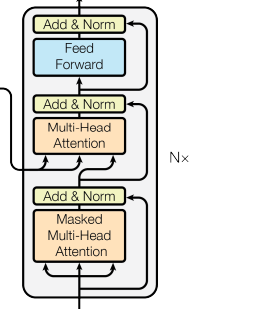

In [16]:
class block(nn.Module):
    #Transformer block:Interspruces communicationa nd computation
    def __init__(self,n_embd,n_head):
        super().__init__()
        head_size=n_embd//n_head
        self.sa=multiheadattention(n_head,head_size)
        self.ffwd=feedforward(n_embd)
        self.ln1=nn.LayerNorm(n_embd)
        self.ln2=nn.LayerNorm(n_embd)
        
    def forward(self,x):
        x=x+self.sa(self.ln1(x))
        x=x+self.ffwd(self.ln2(x))
        return x

In [17]:
class gptLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        #each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table=nn.Embedding(vocab_size,n_embd)
        self.position_embedding_table=nn.Embedding(block_size,n_embd)
        self.blocks=nn.Sequential(*[block(n_embd,n_head=n_head) for _ in range(n_layer)])
        self.ln_f=nn.LayerNorm(n_embd)
        self.lm_head=nn.Linear(n_embd,vocab_size)
        
        #better intialisation
        self.apply(self._init_weights)
    
    def _init_weights(self,module):
        if isinstance(module,nn.Linear):
            torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module,nn.Embedding):
            torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)
            
    def forward(self,idx,targets=None):
        B,T=idx.shape
        
        #idx and targets are both (B,T) tensors of integers
        tok_emb=self.token_embedding_table(idx) #(B,T,C)
        pos_emb=self.position_embedding_table(torch.arange(T,device=device)) #(T,C)
        x=tok_emb+pos_emb #(B,T,C)
        x=self.blocks(x) #(B,T,C)
        x=self.ln_f(x) #(B,T,C)
        logits=self.lm_head(x) #(B,T,vocab_size)
        
        if targets is None:
            loss=None
        else:
            B,T,C=logits.shape
            logits=logits.view(B*T,C)
            targets=targets.view(B*T)
            loss=F.cross_entropy(logits,targets)
            
        return logits,loss
    
    def generate(self,idx,max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [18]:
model=gptLanguageModel()
m=model.to(device)

In [19]:
print(sum(p.numel() for p in m.parameters())/1e6,"M params")

10.788929 M params


#### Optimiser

In [20]:
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)

In [21]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2278, val loss 4.2241
step 500: train loss 1.7850, val loss 1.8932
step 1000: train loss 1.4126, val loss 1.5911
step 1500: train loss 1.2754, val loss 1.4866
step 2000: train loss 1.1933, val loss 1.4671
step 2500: train loss 1.1243, val loss 1.4419
step 3000: train loss 1.0649, val loss 1.4553
step 3500: train loss 1.0033, val loss 1.4694
step 4000: train loss 0.9413, val loss 1.4869
step 4500: train loss 0.8805, val loss 1.5198
step 4999: train loss 0.8242, val loss 1.5550


In [22]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


When it is my larem.

SATIS:
At Saint A-

MARCIUS:
Hanniba.

BRUTUS:
You have lusved.

MARCIUS:
Ay.

Messenger:
This news; the voices may have inbecomes it.
Their sufkren, sir, he has you know't.

COMINIUS:
How much to him?

MARCIUS:
I have you will, sir, and be not from them:
He repeal'd you for help in't, captived
From Rome and half.

MARCIUS:
The old sail for is cautelance:
We do immemand, would have yould know so persuades,
I meet, good Cominius.

MARCIIUS:
The ship ood words.

VOLUMNIA:
Men
